# Модель для оптического распознавания капчи

## Скачивание вводных данных: [Капчи](https://www.kaggle.com/fournierp/captcha-version-2-images)

In [3]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  11.2M      0 --:--:-- --:--:-- --:--:--  112M
replace captcha_images_v2/ydd3g.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


## Инициализация

In [4]:
%pip install tensorflow==2.16.1 numpy matplotlib

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.16.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.16.1
Found existing installation: tf_keras 2.15.1
Uninstalling tf_keras-2.15.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/tf_keras-2.15.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tf_keras/*
Proceed (Y/n)? Y
  Successfully uninstalled tf_keras-2.15.1
  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)


In [5]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import tensorflow as tf

В наборе данных имеется 1040 картинок с капчами в формате PNG.
Название каждого файла - слово-ответ на капчу.
Сопоставим каждому символу в строке целое число, для обучения модели.
Аналогично будем сопоставлять прогнозы модели обратно в строки.
Для этого у нас будет два словаря, для сопоставления символов числам и наоборот.

In [6]:
print("Девайсы: ", tf.config.list_physical_devices())

# Путь к папке с данными
data_dir = Path("./captcha_images_v2/")

# Список всех картинок
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Картинок найдено: ", len(images))
print("Слов найдено: ", len(labels))
print("Уникальных символов: ", len(characters))
print("Имеющиеся символы: ", characters)

# Размер партии для обучения и валидации
batch_size = 16

# Требуемый размер изображений
img_width = 200
img_height = 50

# Во сколько раз изображение будет уменьшено.
# У нас будет 2 свёрточных блока,
# у каждого блока будет слой пулинга, который субдескритизирует
# изображение в 2 раза, поэтому итоговый коэффициент будет 4.
downsample_factor = 4

# Максимальная возможная длина капчи
max_length = max([len(label) for label in labels])

Девайсы:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Картинок найдено:  1040
Слов найдено:  1040
Уникальных символов:  19
Имеющиеся символы:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


## Предобработка

In [7]:

# Сопоставление символов к числам
char_to_num = tf.keras.layers.StringLookup(vocabulary=list(characters), mask_token=None)

# Сопоставление чисел обратно к символам
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Берём количество всех картинок
    size = len(images)
    # 2. Делаем массив индексов и, если надо, перемешиваем его
    indices = tf.keras.ops.arange(size)
    if shuffle:
        tf.keras.random.shuffle(indices)
    # 3. Берём размер тренировочной выборки
    train_samples = int(size * train_size)
    # 4. Разделяем данные в наборы для обучения и валидации
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Считываем изображение
    img = tf.io.read_file(img_path)
    # 2. Декодируем и конвертируем в монохром
    img = tf.io.decode_png(img, channels=1)
    # 3. Конвертируем в дробь от 0 до 1
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Изменяем размер изображений под требуемый
    img = tf.keras.ops.image.resize(img, [img_height, img_width])
    # 5. Транспонируем изображение, чтобы ось времени
    # соответствовала ширине изображения
    img = tf.keras.ops.transpose(img, axes=[1, 0, 2])
    # 6. Сопоставляем символы к числам
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Возвращаем словарь с двумя вводными данными для модели
    return {"image": img, "label": label}


## Создаём объекты набора данных

In [8]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Визуализация вводных данных

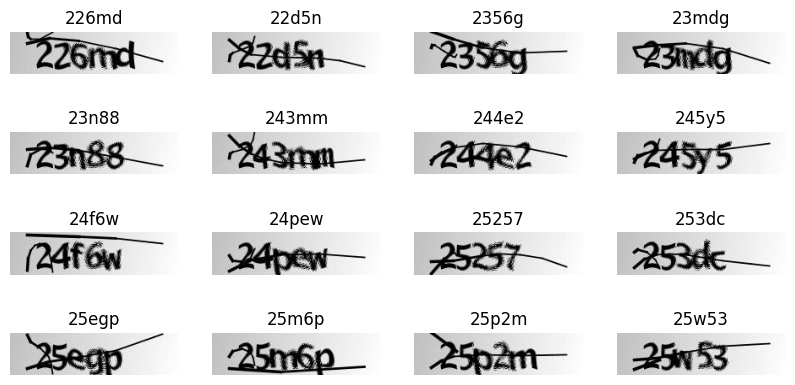

In [9]:

_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Модель

In [10]:

def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.keras.ops.cast(tf.keras.ops.squeeze(label_length, axis=-1), dtype="int32")
    input_length = tf.keras.ops.cast(tf.keras.ops.squeeze(input_length, axis=-1), dtype="int32")
    sparse_labels = tf.keras.ops.cast(
        ctc_label_dense_to_sparse(y_true, label_length), dtype="int32"
    )

    y_pred = tf.keras.ops.log(tf.keras.ops.transpose(y_pred, axes=[1, 0, 2]) + tf.keras.backend.epsilon())

    return tf.keras.ops.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.keras.ops.shape(labels)
    num_batches_tns = tf.keras.ops.stack([label_shape[0]])
    max_num_labels_tns = tf.keras.ops.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.keras.ops.expand_dims(tf.keras.ops.arange(tf.keras.ops.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.keras.ops.cast(tf.fill([1, label_shape[1]], 0), dtype="bool")
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.keras.ops.reshape(
        tf.keras.ops.tile(tf.keras.ops.arange(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.keras.ops.transpose(
        tf.keras.ops.reshape(
            tf.keras.ops.tile(tf.keras.ops.arange(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.keras.ops.transpose(
        tf.keras.ops.reshape(tf.keras.ops.concatenate([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.keras.ops.cast(indices, dtype="int64"),
        vals_sparse,
        tf.keras.ops.cast(label_shape, dtype="int64")
    )


class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.keras.ops.cast(tf.keras.ops.shape(y_true)[0], dtype="int64")
        input_length = tf.keras.ops.cast(tf.keras.ops.shape(y_pred)[1], dtype="int64")
        label_length = tf.keras.ops.cast(tf.keras.ops.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.keras.ops.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.keras.ops.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    # Ввод данных в модель
    input_img = tf.keras.layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = tf.keras.layers.Input(name="label", shape=(None,), dtype="float32")

    # Первый свёрточный слой
    x = tf.keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Второй свёрточный слой
    x = tf.keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Пулинг с размером фильтра и шага 2, с функцией максимума.
    # В итоге, изображение будет в 4 раза меньше.
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # Рекуррентные слои
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Слой вывода
    x = tf.keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Слой классификации по рейтингу, для вычисления потерь при каждом шаге
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Задаём модель
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Оптимизатор
    opt = tf.keras.optimizers.Adam()
    # Компилируем модель
    model.compile(optimizer=opt)
    return model


model = build_model()
model.summary()

Model: "ocr_model_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 200, 50, 32)    │            320 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 100, 25, 32)    │              0 │ Conv1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv2 (Conv2D)            │ (None, 100, 25, 64)    │         18,496 │ pool1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool2 (MaxPooling2D)      │ (None, 50, 12, 64)     │              0 │ Conv2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 50, 768)        │              0 │ pool2[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense1 (Dense)            │ (None, 50, 64)         │         49,216 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 50, 64)         │              0 │ dense1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        197,632 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 50, 128)        │        164,352 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense2 (Dense)            │ (None, 50, 21)         │          2,709 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 50, 21)         │              0 │ label[0][0],           │
│                           │                        │                │ dense2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение

In [11]:

epochs = 100

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
)


Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 44s 372ms/step - loss: 562.0843 - val_loss: 260.1623
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 382ms/step - loss: 266.9704 - val_loss: 259.5503
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 24s 400ms/step - loss: 266.3260 - val_loss: 259.4188
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 364ms/step - loss: 265.8553 - val_loss: 259.7264
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 23s 393ms/step - loss: 265.1844 - val_loss: 260.1942
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 42s 406ms/step - loss: 264.8975 - val_loss: 260.8923
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 383ms/step - loss: 264.3543 - val_loss: 261.2453
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 379ms/step - loss: 263.9154 - val_loss: 261.8420
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 376ms/step - loss: 263.5724 - val_loss: 263.1236
Epoch 10/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 40s 358ms/step - loss: 263.2896 - val_loss: 264.1858
Epoch 11/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 22s 378ms/step - loss: 262.4854 - val_l

## График обучения

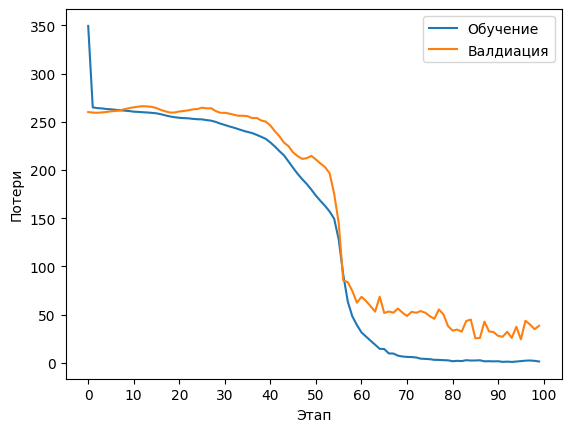

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks(range(0,epochs+1,10))
plt.ylabel("Потери")
plt.xlabel("Этап")
plt.legend(['Обучение', 'Валдиация'], loc='upper right')
plt.show()

## Вывод

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)                   │ (None, 200, 50, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 200, 50, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 100, 25, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 100, 25, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 50, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 50, 768)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1 (Dense)                       │ (None, 50, 64)              │          49,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 50, 256)             │         197,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 50, 128)             │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense2 (Dense)                       │ (None, 50, 21)              │           2,709 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 432,725 (1.65 MB)

 Trainable params: 432,725 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
['x2cnn', 'x347n', 'x362g', 'x37bf', 'c38fn', 'e3deb', 'x3fwf', 'c44n4', 'x458w', 'c4f7g', 'w4gg5', 'x4pnp', 'e5f54', 'x5nyn', 'c6b5m', 'x6pdb']


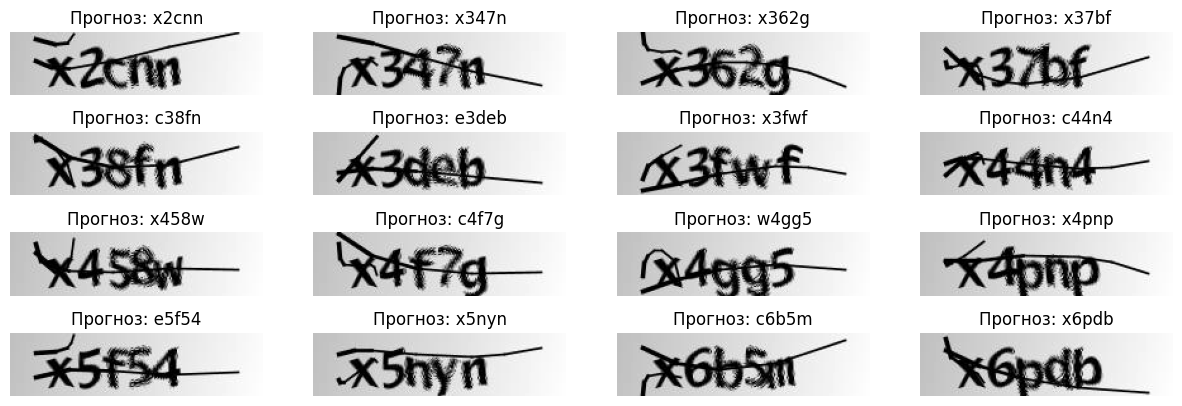

In [13]:

def ctc_decode(y_pred, input_length, greedy=True, beam_width=100, top_paths=1):
    input_shape = tf.keras.ops.shape(y_pred)
    num_samples, num_steps = input_shape[0], input_shape[1]
    y_pred = tf.keras.ops.log(tf.keras.ops.transpose(y_pred, axes=[1, 0, 2]) + tf.keras.backend.epsilon())
    input_length = tf.keras.ops.cast(input_length, dtype="int32")

    if greedy:
        (decoded, log_prob) = tf.nn.ctc_greedy_decoder(
            inputs=y_pred, sequence_length=input_length
        )
    else:
        (decoded, log_prob) = tf.compat.v1.nn.ctc_beam_search_decoder(
            inputs=y_pred,
            sequence_length=input_length,
            beam_width=beam_width,
            top_paths=top_paths,
        )
    decoded_dense = []
    for st in decoded:
        st = tf.SparseTensor(st.indices, st.values, (num_samples, num_steps))
        decoded_dense.append(tf.sparse.to_dense(sp_input=st, default_value=-1))
    return (decoded_dense, log_prob)


# Получаем модель прогноза
prediction_model = tf.keras.models.Model(
    model.input[0], model.get_layer(name="dense2").output
)
prediction_model.summary()


# Расшифровка прогноза
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Пробегаемся по результатам и возвращаем текст
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Проверяем на случайной выборке для валидации
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    print(pred_texts)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Прогноз: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()